In [2]:
import datetime
import logging

import requests
import os
import joblib

import numpy as np
import pandas as pd
pd.options.display.max_columns = 300

from pathlib import Path
import warnings
import sys
print(sys.path)
sys.path.append('../modules/')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
from lightgbm import LGBMModel
import matplotlib.pyplot as plt

['/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/notebooks', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '', '/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages', '/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/IPython/extensions', '/Users/shugo/.ipython']


In [93]:
ROOT = '/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421'

# make config
INPUT = os.path.join(ROOT, 'input') # パスの結合
OUTPUT = os.path.join(ROOT, 'output')
SUBMISSION = os.path.join(ROOT, 'submission')

EXP_NAME = 'main'
EXP = os.path.join(OUTPUT, EXP_NAME)
PREDS = os.path.join(EXP, 'preds')
TRAINED = os.path.join(EXP, 'trained')
FEATURE = os.path.join(EXP, 'feature')
REPORTS = os.path.join(EXP, 'reports')

# make experiments environment
dirs = [
        OUTPUT,
        SUBMISSION,
        FEATURE,
        EXP,
        PREDS,
        TRAINED,
        REPORTS
        ]

# パスが通ってなかったら、新しいパスを通す
for v in dirs:
    if not os.path.isdir(v):
        print(f'making {v}')
        os.makedirs(v, exist_ok=True)

making /Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/output/main/feature
making /Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/output/main/preds
making /Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/output/main/trained
making /Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/output/main/reports


# Load data

In [94]:
train = pd.read_csv(INPUT+'/train.csv')
test = pd.read_csv(INPUT+'/test.csv')
sample_sub = pd.read_csv(INPUT+'/sample_submit.csv')
genre_labels = pd.read_csv(INPUT+'/genre_labels.csv')

In [95]:
# save and load用のクラス
class Util:
    @classmethod
    def dump(cls, value, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        joblib.dump(value, path, compress=True) # 並列処理
        
    @classmethod
    def load(cls, path):
        return joblib.load(path)
    
# log用のクラス
class Logger:
    def __init__(self, path):
        self.general_logger = logging.getLogger(path) # loggerを設定
        stream_handler = logging.StreamHandler() # loggerからlogRecordを渡される
        file_general_handler = logging.FileHandler(os.path.join(path, 'Experiment.log'))
        if len(self.general_logger.handlers) == 0:
            self.general_logger.addHandler(stream_handler)
            self.general_logger.addHandler(file_general_handler)
            self.general_logger.setLevel(logging.INFO)
            
    def info(self, message):
        # display time
        self.general_logger.info('[{}] - {}'.format(self.now_string(), message))
    
    @staticmethod
    def now_string():
        return str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
# loggerの設定
logger = Logger(REPORTS) # REPORTフォルダにlog結果を保存する

In [96]:
N_CLASSES = 11

# testのジャンルを-100として結合
def merge_train_test(train, test):
    if 'genre' not in test.columns.tolist():
        test['genre'] = -100
    res = pd.concat([train,test])
    res.reset_index(inplace=True, drop = True)
    return res

def split_train_test(input_df):
    train = input_df[input_df['genre'] != -100]
    test = input_df[input_df['genre'] == -100]
    train.reset_index(inplace=True, drop=True)
    test.reset_index(inplace=True, drop =True)
    return train, test

df = merge_train_test(train, test)

# Feature Enginnering
  ## class

In [97]:
# regionについてgroupbyし、その出現頻度をcountする
class CountEncoder:
    def fit(self, series):
        self.counts = series.groupby(series).count()
        return self
    
    def transform(self, series):
        return series.map(self.counts).fillna(0)
    
    def fit_transform(self, series):
        return self.fit(series).transform(series)
    

#　標準偏差とz得点
class GroupFeatureExtractor:
    EX_TRANS_METHODS = ['deviation', 'zscore']
    
    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values
        
        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df_train, y=None):
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_methods): # 呼び出し可能か判定
                agg_method_name = agg_method.__name__ # ?
            else:
                agg_method_name = agg_method
            df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_columns_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()
        
    def transform(self, df_eval):
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how='left')
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if 'deviation' in self.ex_trans_methods:
                df_features[self._get_column_names('deviation')] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform('mean')
            if 'zscore' in self.ex_trans_methods:
                df_features[self._get_column_names('zscore')] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform('mean')) \
                                                                                                            / (df_eval[[key]+self.group_values].groupby(key).transform('std') + 1e-8)
            df_features.drop(self.group_key, axis=1, inplace = True)
            return df_features
        
    def _get_column_names(self, method):
        return [f'agg_{method}_{col}_grpby_{self.group_key}' for col in self.group_values]
        
    def fit_transform(self, df_train, y=None):
        self.fit(df_train, y=y)
        return self.transform(df_train)


# K近傍法特徴量
class KNNFeatureExtractor:
    def __init__(self, n_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors + 1)
        
    def fit(self, X, y):
        self.knn.fit(X, y)
        self.y = y if isinstance(y, np.ndarray) else np.array(y) # 型判定の組み込み関数isinstanceはboolを返す。np.arrayのyを返す
        return self

    def transform(self, X, is_train_data):
        distances, indexes = self.knn.kneighbors(X) # ポイントXから最も近いポイントまでの距離と、そのインデックスを返す
        
        # train, testデータを判定
        distances = distances[:, 1:] if is_train_data else distances[:, :-1]
        indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
        labels = self.y[indexes]
        score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
        df_knn = pd.DataFrame(
                [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)], # bincount : 要素の個数を返す
                columns=score_columns
        )
        
        # 最大スコア
        df_knn['max_knn_scores'] = df_knn.max(axis=1)
        
        # 最大スコアとの差。0は最大スコアを表す
        for col in score_columns:
            df_knn[f'sub_max_knn_scores_{col}'] = df_knn['max_knn_scores'] - df_knn[col]
        
        # 最大スコアとの比。1は最大スコアを表す
        for col in score_columns:
            df_knn[f'ratio_max_knn_scores_{col}'] = df_knn[col] / df_knn['max_knn_scores']
        
        # それぞれのスコア同士の差
        for i, col1 in enumerate(score_columns):
            for j, col2 in enumerate(score_columns[i+1:], i+1): # 全パターンを網羅できる
                df_knn[f'sub_{col1}_{col2}'] = df_knn[col1] - df_knn[col2]
        
        # knnスコアの合計
        df_knn['sum_knn_scores'] = df_knn.sum(1)
        
        return df_knn

## 関数

In [98]:
n_train = len(train)
def get_target(input_df):
    global n_train
    if 'genre' in input_df.columns:
        output_df = input_df['genre'][:n_train]
        return output_df

def get_numerical_features(input_df):
    # そのままの数値特徴
    cols = ['popularity',
            'duration_ms',
            'acousticness',
            'positiveness',
            'danceability',
            'loudness',
            'energy',
            'liveness',
            'speechiness',
            'instrumentalness']
    output_df = input_df[cols].copy()
    return output_df

def get_genre_name(input_df):
    output_df = pd.DataFrame()
    output_df['genre_name'] = input_df['genre'].map(dict(genre_labels[['labels', 'genre']].values)).copy()
    return output_df
   
def get_tempo_features(input_df):
    _df = input_df['tempo'].str.split('-').apply(pd.Series).astype(float)
    _df.columns = ['tempo_low', 'tempo_high']
    output_df = _df.copy()
    output_df['mean_tempo'] = (_df['tempo_high'] + _df['tempo_low'])/2
    output_df['diff_tempo'] = _df['tempo_high'] - _df['tempo_low']
    output_df['var_tempo'] = _df.var(axis=1) # tempo_highとtempo_lowの分散をとる
    output_df['sum_tempo'] = _df.sum(axis=1)
    output_df['log_tempo'] = np.log(output_df['mean_tempo'])
    return output_df

def get_region_onehot(input_df):
    # regionをone-hotし、unknownをregion_unknownとする
    output_df = pd.get_dummies(input_df['region']).rename(columns={'unknown' : 'region_unknown'})
    return output_df

def get_num_nans(input_df):
    # 曲ごとのnanの数
    input_df['num_nans'] = 0
    for col in [
        'acousticness',
        'positiveness',
        'danceability',
        'energy',
        'liveness',
        'speechiness',
        'instrumentalness'
    ]:
        input_df['num_nans'] += input_df[col].isna()
        output_df = input_df['num_nans'].apply(pd.Series)
        output_df.columns = ['num_nans']
        return output_df

def get_ce_features(input_df):
    columns_count_enc = ['region']
    output_df = pd.DataFrame()
    for col in columns_count_enc:
        output_df['countenc_' + col] = CountEncoder().fit_transform(input_df[col])
        output_df.loc[input_df[col].isna().values, 'countenc_' + col]= np.nan
    return output_df
    
def get_le_features(input_df):
    columns_count_enc = ['region']
    output_df = pd.DataFrame()
    for col in columns_count_enc:
        output_df['labelenc_' + col] = LabelEncoder().fit_transform(input_df[col])
        output_df.loc[input_df[col].isna().values, 'labelenc_' + col]= np.nan
    return output_df

def get_standardscaled_features(input_df):
    output_df = pd.DataFrame()
    _input_df = pd.concat([get_numerical_features(input_df),
                           get_tempo_features(input_df),
                           get_num_nans(input_df)], axis=1)
    for col in [
        'popularity', 'duration_ms', 'acousticness',
        'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
        'speechiness', 'instrumentalness', 'log_tempo', 'num_nans'
    ]:
        output_df['standardscaled_' + col] = StandardScaler().fit_transform(_input_df[[col]])[:, 0]
    
    return output_df

# regionをキーにした集約統計量
def get_agg_region_features(input_df):
    _input_df = pd.concat([get_numerical_features(input_df),
                          get_tempo_features(input_df),
                          input_df[['region']]], axis=1)
    group_key = 'region'
    group_values = ['popularity',
                    'duration_ms',
                    'acousticness',
                    'positiveness',
                    'danceability',
                    'loudness',
                    'energy',
                    'liveness',
                    'speechiness',
                    'instrumentalness', 
                    'tempo_low', 
                    'tempo_high',
                    'log_tempo']
    agg_methods = ['deviation', 'zscore']
    gfe = GroupFeatureExtractor(
        group_key=group_key,
        group_values=group_values,
        agg_methods=agg_methods)
    output_df = gfe.fit_transform(_input_df)
    return output_df

# k近傍法特徴量
# input : merge_train_test(train, test)
# output : train_knn_features, test_knn_features
def get_knn_features(input_df): # train or test
    knn_n_neighbors = 6
    
    region_onehot = get_region_onehot(input_df).columns.values.tolist()
    standardscaled_features = get_standardscaled_features(input_df).columns.values.tolist()
    knn_features = region_onehot + standardscaled_features
    
    dict_feature_weights = {}
    
    for col in region_onehot:
        dict_feature_weights[col] = 100.0

    # 標準化されているものは重みを0とする
    for col in standardscaled_features:
        dict_feature_weights[col] = 1.0

    dict_feature_weights["standardscaled_popularity"] = 8.0
    dict_feature_weights["standardscaled_log_tempo"] = 0.001
    dict_feature_weights["standardscaled_num_nans"] = 100.0

    knn_feature_weights = np.array([dict_feature_weights[col] for col in knn_features])
    
    
    _input_df = pd.concat([input_df,
                           get_region_onehot(input_df),
                          get_standardscaled_features(input_df)], axis=1)
    
    train, test = split_train_test(_input_df)
    target = get_target(train)
    
    train_x = train[knn_features].fillna(0.0).values * knn_feature_weights
    test_x = test[knn_features].fillna(0.0).values * knn_feature_weights
    # fit
    knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(train_x, target)
    # transform
    train_knn_features  = knn_feature_extractor.transform(train_x, is_train_data=True)
    test_knn_features = knn_feature_extractor.transform(test_x, is_train_data=False)
    
    output_df = pd.concat([train_knn_features, test_knn_features], axis=0)
    return output_df

In [99]:
# 上で作った関数を実行し、train, testそれぞれで処理を行う

def preprocess(input_df, funcs, task='train'):
    df_lst = []
    for func in funcs:
        file_name = os.path.join(FEATURE, f'{task}_{func.__name__}.pkl')
        # パスが通っていたら、その中身を返す
        if os.path.isfile(file_name):
            _df = Util.load(file_name)
        # 通ってなかったら
        else:
            _df = func(input_df)
            Util.dump(_df, file_name)
        df_lst.append(_df)
    output_df = pd.concat(df_lst, axis=1)
    return output_df

def get_train_data(train, test):
    # each_funcs : trainのみを対象とした処理
    each_funcs = [get_numerical_features,
                 get_tempo_features,
                 get_num_nans,
                 get_ce_features,
                 get_le_features,
                 get_standardscaled_features,
                 get_agg_region_features
                 ]
    train_out = preprocess(train, each_funcs, task='train') # each_funcsによる前処理
    
    # whole_funcs : train+testの全体集合を対象とした処理
    whole_funcs = [get_knn_features]
    whole_df = pd.concat([train, test], axis=0).reset_index(drop=True) # whole_funcs用のデータ
    whole_out = preprocess(whole_df, whole_funcs, task='whole') # whole_funcsによる前処理
    train_x = pd.concat([train_out,
                        whole_out.iloc[:len(train)]], axis=1)
    return train_x

def get_test_data(train, test):
    # each_funcs : testのみを対象とした処理
    each_funcs = [get_numerical_features,
                 get_tempo_features,
                 get_num_nans,
                 get_ce_features,
                 get_le_features,
                 get_standardscaled_features,
                 get_agg_region_features
                 ]
    test_out = preprocess(test, each_funcs, task='test')
    
    # whole_funcs : train+testの全体集合を対象とした処理
    whole_funcs = [get_knn_features]
    whole_df = pd.concat([train, test]).reset_index(drop=True)
    whole_out = preprocess(whole_df, whole_funcs, task='whole') # whole_funcsによる前処理
    test_x = pd.concat([test_out,
                       whole_out.iloc[len(train):].reset_index(drop=True)], axis=1)
    return test_x

In [100]:
# get features, 前処理の実行部分
train_x = get_train_data(train, test)
test_x = get_test_data(train, test)
train_y = train['genre']
print('train_x', train_x.shape)
print('train_y', train_y.shape)
print('test_x', test_x.shape)

train_x (4046, 148)
train_y (4046,)
test_x (4046, 148)


# train

In [101]:
def skf(train_x, train_y, n_splits, random_state=71, key=None):
    kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    return list(kf.split(train_x, train_y, key))

def macro_f1(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=1)
    score = f1_score(y_true, y_pred, average='macro')
    return score

In [102]:
# feature importanceを出力&可視化
def tree_importance(X, y, model, model_params, fit_params, cv, cv_key, folds):
    est = model(model_params, fit_params)
    feature_importance_df = pd.DataFrame()
    for i, (train_idx, valid_idx) in enumerate(cv(X, y, n_splits=folds, key=cv_key)):
        train_x, valid_x = X.values[train_idx], X.values[valid_idx]
        train_y, valid_y = y.values[train_idx], y.values[valid_idx]
        est.fit(train_x, train_y, valid_x, valid_y)
        _df = pd.DataFrame()
        _df['feature_importance'] = est.model.feature_importances_
        _df['column'] = X.columns
        _df['fold'] = i+1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)
    order = feature_importance_df.groupby('column') \
                .sum()[['feature_importance']] \
                .sort_values('feature_importance', ascending=False).index[:150]
    fig, ax = plt.subplots(figsize=(12, max(4, len(order)*.2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax,
                 palette='viridis')
    fig.tight_layout()
    ax.grid()
    ax.set_title('feature importance')
    fig.tight_layout()
    return fig, feature_importance_df

In [129]:
# training用のcv
def train_cv(X, y, model,
            model_params,
            cv, cv_key,
            folds, seeds,
            metrics,
            name=''):
    oof_seeds, scores_seeds = [], []
    for seed in seeds:
        oof, va_idxes, scores = [], [], []
        train_x, train_y = X.values, y.values
        fold_idx = cv(train_x, train_y, n_splits=folds, random_state=seed, key=cv_key)
        if 'random_state' in model_params:
            model_params['random_state'] = seed
            
        # train and predict by cv folds
        for cv_num, (train_idx, valid_idx) in enumerate(fold_idx):
            trn_x = train_x[train_idx]
            val_x = train_x[valid_idx]
            trn_y = train_y[train_idx]
            val_y = train_y[valid_idx]
            
            va_idxes.append(valid_idx)
            est = model(model_params, fit_params)
            
            # fitting - train
            est.fit(trn_x, trn_y, val_x, val_y)
            model_name = os.path.join(TRAINED, f'{name}_SEED{seed}_FOLD{cv_num}_model.pkl')
            est.save(model_name) # save model
            
            # predict - validation
            pred = est.predict(val_x)
            oof.append(pred)
            
            # validation score
            score = metrics(val_y, pred)
            scores.append(score)
            logger.info(f'SEED:{seed}, FOLD:{cv_num} >>>> val_score:{score:.4f}')
        # sort as default
        va_idxes = np.concatenate(va_idxes)
        oof = np.concatenate(oof)
        order = np.argsort(va_idxes)
        oof = oof[order]
        oof_seeds.append(oof)
        scores_seeds.append(np.mean(scores))
        logger.info(f'seed:{seed} score:{metrics(train_y, oof):.4f}\n')
        
    
    oof = np.mean(oof_seeds, axis=0)
    Util.dump(oof, f'{PREDS}/oof.pkl')
    logger.info(f'model:{name} score{metrics(train_y, oof):.4f}\n')
    return oof


# predict用の関数
def predict_cv(X, model, folds, seeds, name=''):
    preds_seeds = []
    for seed in seeds:
        preds = []
        for i_fold in range(folds):
            logger.info(f'PREDICT >>> SEED:{seed}, FOLD:{i_fold}')
            model_name = os.path.join(TRAINED, f'{name}_SEED{seed}_FOLD{i_fold}_model.pkl')
            est = model()
            est.load(model_name)
            pred = est.predict(test_x.values)
            preds.append(pred)
        preds = np.mean(preds, axis=0)
        preds_seeds.append(preds)

    preds = np.mean(preds_seeds, axis=0)
    Util.dump(preds, f'{PREDS}/preds.pkl')
    return preds

In [130]:
# LightGBMのラッパー : 上のtrain_cv, predict_cvを色々なモデルで使いまわす
class MyLGBMModel:
    def __init__(self, model_params=None, fit_params=None):
        self.model_params = model_params
        self.fit_params = fit_params
        self.model = None
        
    def build_model(self):
        self.model = LGBMModel(**self.model_params)
        
    def fit(self, train_x, train_y, valid_x=None, valid_y=None):
        self.build_model()
        self.model.fit(train_x, train_y,
                      eval_set=[[valid_x, valid_y]],
                      **self.fit_params)
        
    def predict(self, x):
        preds = self.model.predict(x)
        return preds
    
    def save(self, path):
        Util.dump(self.model, path)
    
    def load(self, path):
        self.model = Util.load(path)
        
        
# 今回は使ってないですが、catboost ならこんな感じ

# class MyCatBoostClassifier:
#     def __init__(self, model_params=None, fit_params=None):
#         self.model_params = model_params
#         self.fit_params = fit_params

#     def build_model(self):
#         self.model = CatBoostClassifier(**self.model_params)

#     def fit(self, tr_x, tr_y, va_x=None, va_y=None):
#         self.build_model()
#         tr_pool = Pool(tr_x, tr_y)
#         va_pool = Pool(va_x, va_y)
#         self.model.fit(tr_pool,
#                        eval_set=[va_pool],
#                        **self.fit_params)

#     def predict(self, x):
#         preds = self.model.predict(x, prediction_type='Probability')
#         return preds

#     def save(self, path):
#         Util.dump(self.model, path)
    
#     def load(self, path):
#         self.model = Util.load(path)

In [155]:
# set model
model = MyLGBMModel

learning_rate = 0.01
model_params['learning_rate'] = learning_rate + np.random.random() * 0.001 # おまじない
N_CLASSES = 11
num_round = 999999
# モデルのパラメータ
model_params = {
    'num_round':num_round,
    'num_class' : N_CLASSES,
    'objective':'multiclass',
    'learning_rate':learning_rate,
    'num_leaves':3,
    'random_state':71,
    'min_data_in_leaf':40,
    #'importance_type':'gain',
    #'colsample_bytree':.5,
    #'class_weight':'balanced' # 逆ラベル頻度
}

early_stopping_rounds = 300 if num_round >=1e8 else None
#fit時のパラメータ
fit_params = {
    #'early_stopping_rounds':100,
    #'verbose':100,
    'verbose':300,
    'early_stopping_rounds' : 300#early_stopping_rounds,
}

# stratified kfoldのキーを設定
cv_key = train_y.copy() # genreごとにskf

# logに保存
logger.info(f'MODEL: {model.__name__}')
logger.info(f'model_params: {model_params}')
logger.info(f'fit_params: {fit_params}')

[2021-05-06 15:39:47] - MODEL: MyLGBMModel
[2021-05-06 15:39:47] - model_params: {'num_round': 999999, 'num_class': 11, 'objective': 'multiclass', 'learning_rate': 0.01, 'num_leaves': 3, 'random_state': 71, 'min_data_in_leaf': 40}
[2021-05-06 15:39:47] - fit_params: {'verbose': 300, 'early_stopping_rounds': 300}


In [156]:
# set n folds and seeds
folds = 15 # fold数
seeds = [71] # 複数取るとseedの平均を返す

# logに保存
logger.info(f'folds: {folds}')
logger.info(f'seeds: {seeds}')

# train
oof = train_cv(X=train_x,
              y=train_y,
              model=model,
              model_params=model_params,
              cv=skf,
              cv_key=cv_key,
              folds=folds,
              seeds=seeds,
              metrics=macro_f1,
              name='test')

[2021-05-06 15:39:48] - folds: 15
[2021-05-06 15:39:48] - seeds: [71]
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.935269
[600]	valid_0's multi_logloss: 0.937194


[2021-05-06 15:39:53] - SEED:71, FOLD:0 >>>> val_score:0.5837


Early stopping, best iteration is:
[363]	valid_0's multi_logloss: 0.933786
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.80404
[600]	valid_0's multi_logloss: 0.784769
[900]	valid_0's multi_logloss: 0.781873
Early stopping, best iteration is:
[840]	valid_0's multi_logloss: 0.780714


[2021-05-06 15:40:01] - SEED:71, FOLD:1 >>>> val_score:0.7235
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999
Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.741475
[600]	valid_0's multi_logloss: 0.708767
[900]	valid_0's multi_logloss: 0.702525
[1200]	valid_0's multi_logloss: 0.702064
Early stopping, best iteration is:
[1144]	valid_0's multi_logloss: 0.700961


[2021-05-06 15:40:19] - SEED:71, FOLD:2 >>>> val_score:0.6818
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999
Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.924054
[600]	valid_0's multi_logloss: 0.916659
Early stopping, best iteration is:
[468]	valid_0's multi_logloss: 0.91532


[2021-05-06 15:40:29] - SEED:71, FOLD:3 >>>> val_score:0.5167
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999
Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.8897
[600]	valid_0's multi_logloss: 0.883938
Early stopping, best iteration is:
[472]	valid_0's multi_logloss: 0.882627


[2021-05-06 15:40:38] - SEED:71, FOLD:4 >>>> val_score:0.6362
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999
Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.887649
[600]	valid_0's multi_logloss: 0.870123
[900]	valid_0's multi_logloss: 0.870323
Early stopping, best iteration is:
[763]	valid_0's multi_logloss: 0.868628


[2021-05-06 15:40:49] - SEED:71, FOLD:5 >>>> val_score:0.6549
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999
Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.781641
[600]	valid_0's multi_logloss: 0.775213
Early stopping, best iteration is:
[465]	valid_0's multi_logloss: 0.772927


[2021-05-06 15:41:02] - SEED:71, FOLD:6 >>>> val_score:0.7097
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999
Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.840075
[600]	valid_0's multi_logloss: 0.823574
Early stopping, best iteration is:
[597]	valid_0's multi_logloss: 0.823283


[2021-05-06 15:41:15] - SEED:71, FOLD:7 >>>> val_score:0.6729
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999
Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.85398
[600]	valid_0's multi_logloss: 0.830378
[900]	valid_0's multi_logloss: 0.824344
[1200]	valid_0's multi_logloss: 0.823954
Early stopping, best iteration is:
[1124]	valid_0's multi_logloss: 0.823697


[2021-05-06 15:41:31] - SEED:71, FOLD:8 >>>> val_score:0.5925
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999
Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.837321
[600]	valid_0's multi_logloss: 0.818833
[900]	valid_0's multi_logloss: 0.811676
[1200]	valid_0's multi_logloss: 0.810304
Early stopping, best iteration is:
[1069]	valid_0's multi_logloss: 0.80854


[2021-05-06 15:41:48] - SEED:71, FOLD:9 >>>> val_score:0.6466
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999
Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.763536
[600]	valid_0's multi_logloss: 0.742937
[900]	valid_0's multi_logloss: 0.739041
[1200]	valid_0's multi_logloss: 0.737036
[1500]	valid_0's multi_logloss: 0.738946
Early stopping, best iteration is:
[1300]	valid_0's multi_logloss: 0.73629


[2021-05-06 15:42:05] - SEED:71, FOLD:10 >>>> val_score:0.6960
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999
Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.869242
[600]	valid_0's multi_logloss: 0.866056
Early stopping, best iteration is:
[441]	valid_0's multi_logloss: 0.86382


[2021-05-06 15:42:13] - SEED:71, FOLD:11 >>>> val_score:0.6275
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999
Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.843564
[600]	valid_0's multi_logloss: 0.825525
[900]	valid_0's multi_logloss: 0.823309
Early stopping, best iteration is:
[865]	valid_0's multi_logloss: 0.822367


[2021-05-06 15:42:28] - SEED:71, FOLD:12 >>>> val_score:0.6746
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999
Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.851125
[600]	valid_0's multi_logloss: 0.836871
Early stopping, best iteration is:
[518]	valid_0's multi_logloss: 0.836469


[2021-05-06 15:42:39] - SEED:71, FOLD:13 >>>> val_score:0.6028
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] num_iterations is set=999999, num_round=999999 will be ignored. Current value: num_iterations=999999
Training until validation scores don't improve for 300 rounds
[300]	valid_0's multi_logloss: 0.74665
[600]	valid_0's multi_logloss: 0.719202
[900]	valid_0's multi_logloss: 0.711153
[1200]	valid_0's multi_logloss: 0.708747
Early stopping, best iteration is:
[1174]	valid_0's multi_logloss: 0.708585


[2021-05-06 15:43:00] - SEED:71, FOLD:14 >>>> val_score:0.7044
[2021-05-06 15:43:00] - seed:71 score:0.6612

[2021-05-06 15:43:00] - model:test score0.6612



[LightGBM] [Warning] Unknown parameter: n_job
[LightGBM] [Warning] Unknown parameter: n_classes
[LightGBM] [Warning] Unknown parameter: n_estimator
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.08244
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.08244
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.1326
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.1326
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.1199
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.1199
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.06754
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.06754
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.0795
Did 

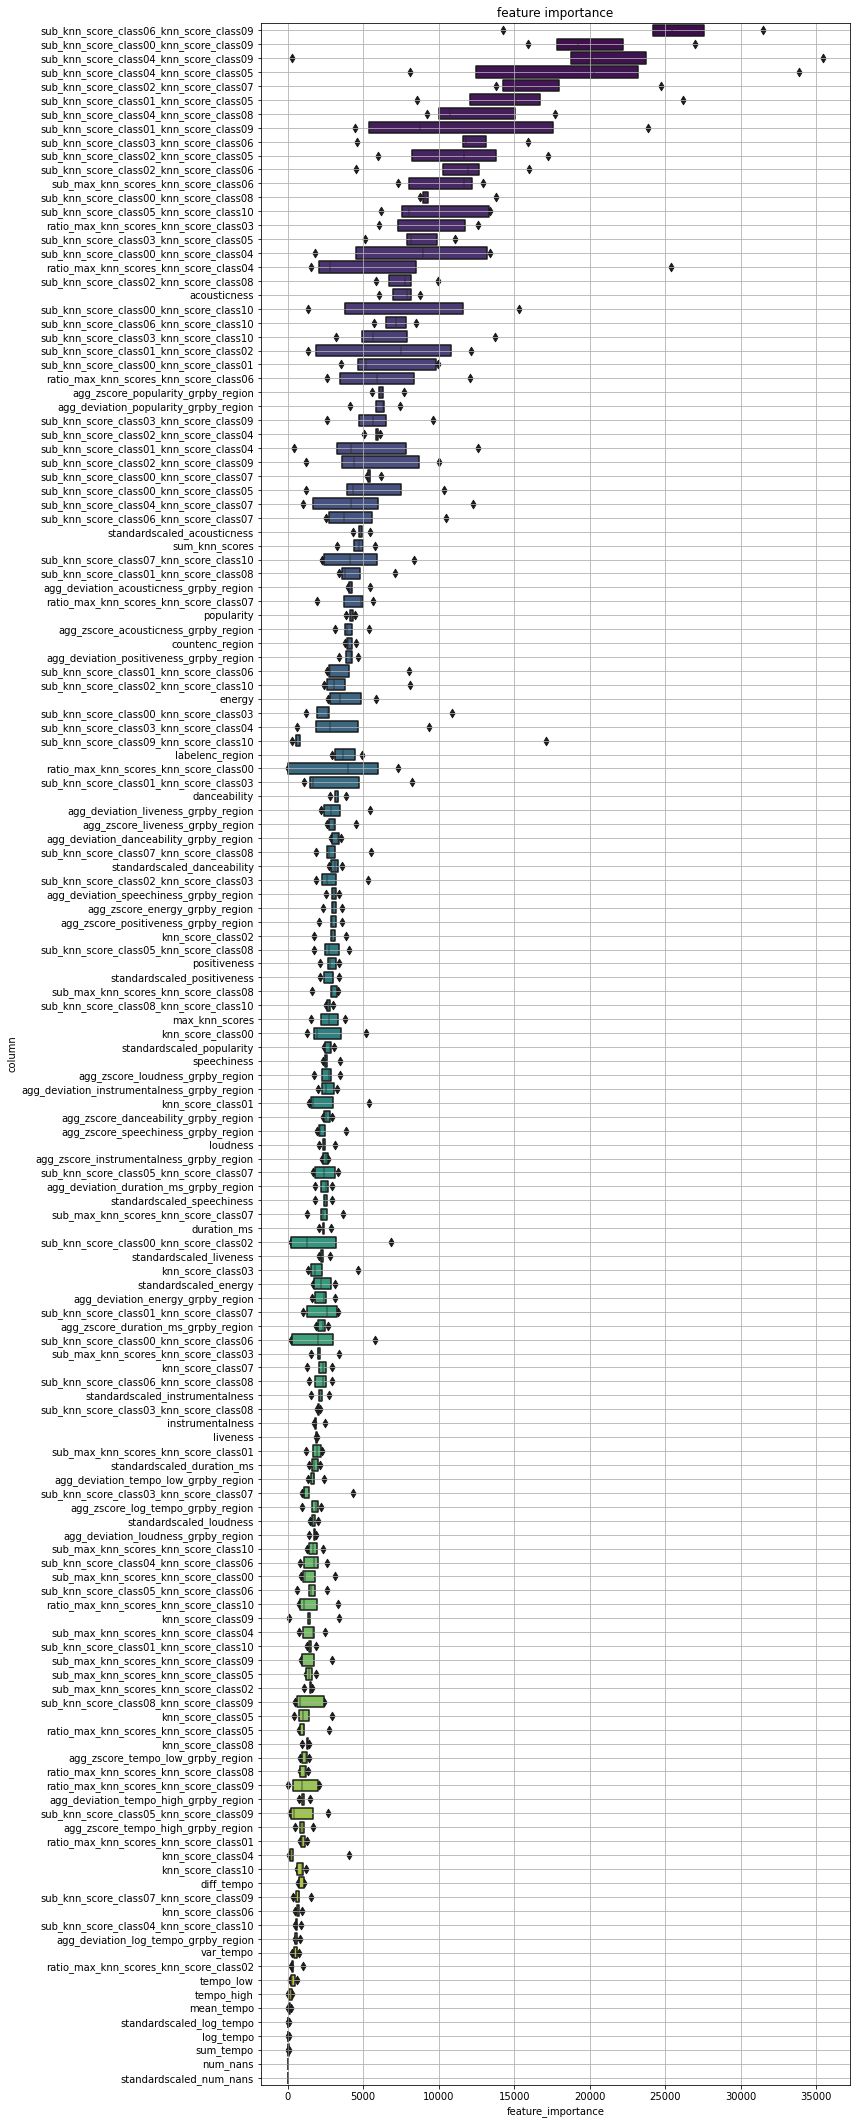

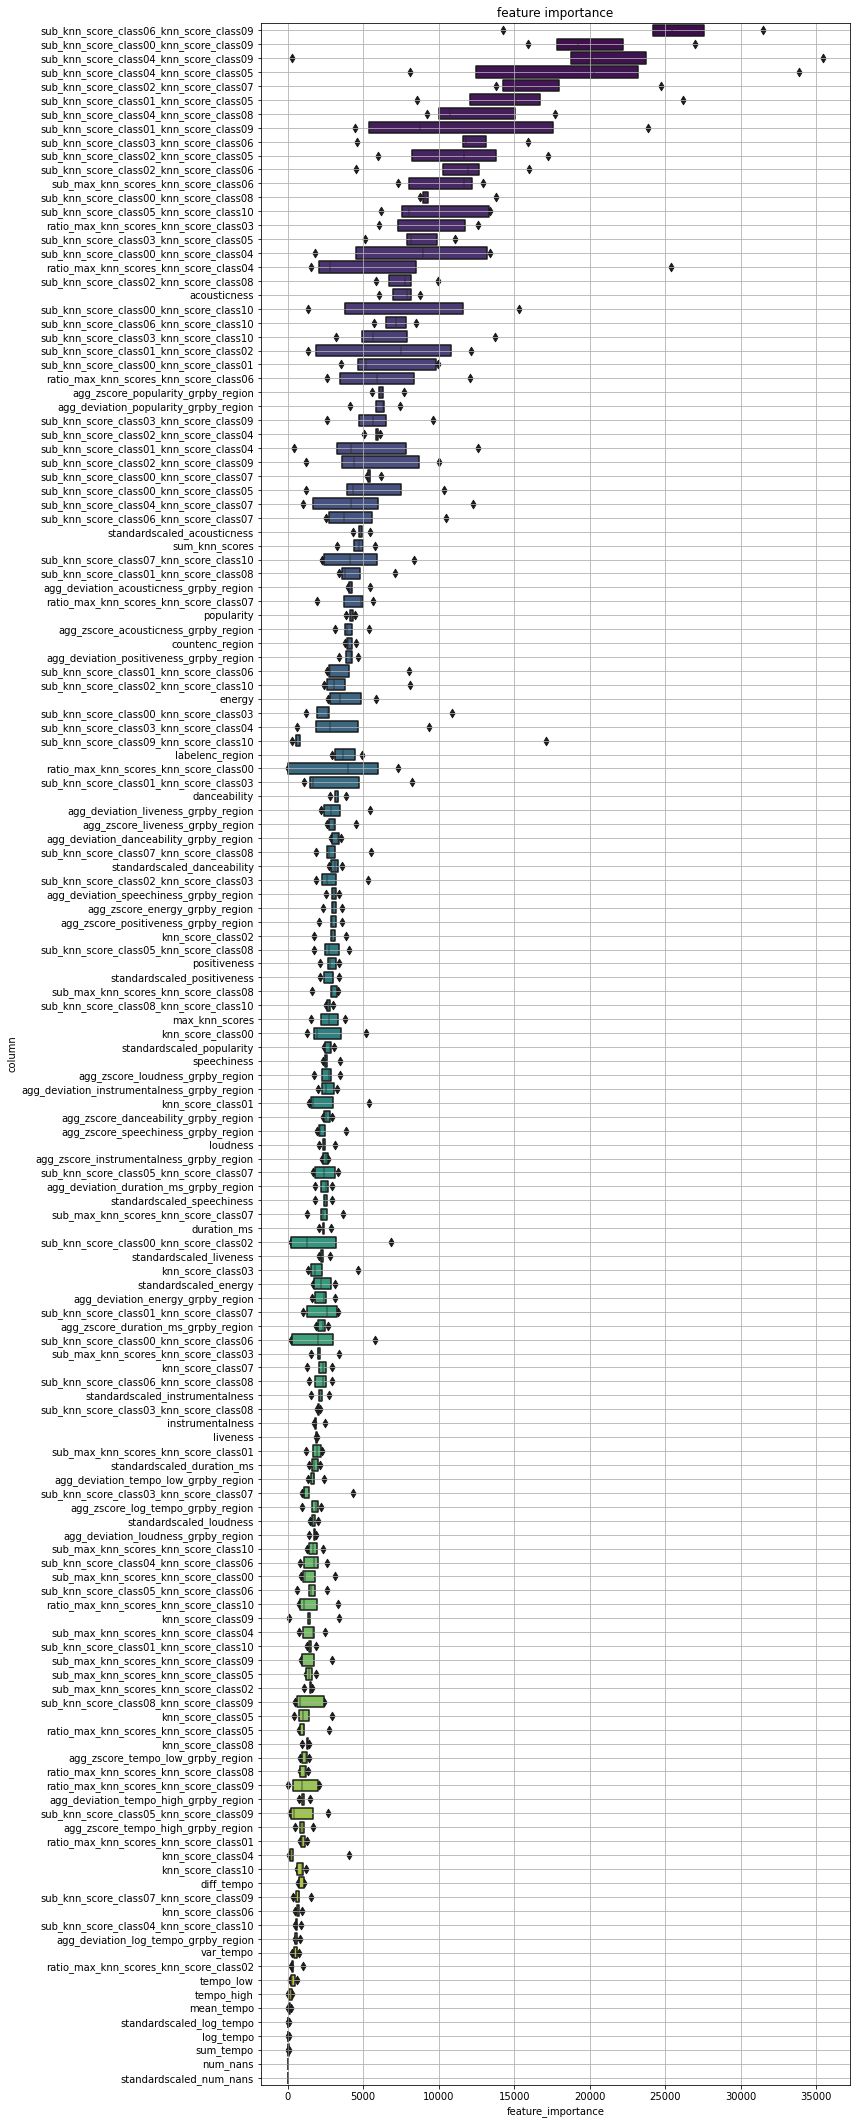

In [133]:
# tree importanceを表示
fig, _df = tree_importance(train_x,
                          train_y,
                          model,
                          model_params,
                          fit_params,
                          cv=skf,
                          cv_key=cv_key,
                          folds=5)
fig
# save fig $ csv
#fig.savefig(f'{REPORTS}/tree_importance.png', dpi=150)
#_df.to_csv(f'{REPORTS}/tree_importance.csv', index=None)

# Submission

In [ ]:
df_sample_sub['genre'] = predictions.argmax(axis=1)
display(df_sample_sub)
df_sample_sub.to_csv('../outputs/sub_0501.csv', index=False, header=False)